### Imports and Global Class and Function Definitions

In [1]:
import torch.nn as nn
import torch as torch
import pandas as pd
import cv2
from tqdm import tqdm
import os
from typing import List, Tuple
import matplotlib.pyplot as plt



# Softmax image classifier class
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SoftmaxClassifier, self).__init__()
        
        # Single fully connected layer
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        
        # Compute raw logits
        logits = self.linear(x)
        return logits


# Function to get the input dimension of a colored image
def get_input_dim(image_path):
    img_array = cv2.imread(image_path)
    flattened_array = img_array.reshape(-1)
    return len(flattened_array)


# Function to flatten a colored image into a 1D array
def flatten_image(image_path):
    img_array = cv2.imread(image_path)
    img_array = cv2.resize(img_array, (426, 320))
    flattened_array = torch.from_numpy(img_array.reshape(-1)).float()
    flattened_array = flattened_array
    return flattened_array

### Miscellaneous Testing Functions

In [2]:
# Function to resize an image to 426x320
def resize_image(image_path):
    # Read image
    img = cv2.imread(image_path)
    # Resize to 426x320
    resized_img = cv2.resize(img, (426, 320))
    return resized_img


# Using OpenCV (cv2)
def save_as_jpeg_cv2(numpy_array, output_path):
    """
    Save a numpy array as a JPEG image.
    
    Args:
        numpy_array: NumPy array of image (height, width, 3) in BGR format
        output_path: String path where to save the image (e.g., 'output.jpg')
    """
    success = cv2.imwrite(output_path, numpy_array)
    if success:
        print(f"Image successfully saved to {output_path}")
    else:
        print("Failed to save image")
        

# Count total files in directory and subdirectories
def count_files(directory):
    total = 0

    for root, dirs, files in os.walk(directory):
        total += len(files)
    return total

### Configuration

#### Model Configurations

In [3]:
# Model configuration
init_image_path = "/Users/ericcui/repos/imagenette/imagenette2-320/train/n01440764/ILSVRC2012_val_00000293.JPEG"
num_classes = 10
num_epochs = 10

# CSV processing configuration
train_image_label_csv = "/Users/ericcui/repos/imagenette/imagenette2-320/randomized_train.csv"
val_image_label_csv = "/Users/ericcui/repos/imagenette/imagenette2-320/val_imagenette.csv"
path_prefix = "/Users/ericcui/repos/imagenette/imagenette2-320/"

# Label to index mappings
label_index_mappings = {
    "n01440764": 0,
    "n02102040": 1,
    "n02979186": 2,
    "n03000684": 3,
    "n03028079": 4,
    "n03394916": 5,
    "n03417042": 6,
    "n03425413": 7,
    "n03445777": 8,
    "n03888257": 9,
}

# Label to class mappings
class_mappings = {
    "n01440764": "tench",
    "n02102040": "English springer",
    "n02979186": "cassette player",
    "n03000684": "chain saw",
    "n03028079": "church",
    "n03394916": "French horn",
    "n03417042": "garbage truck",
    "n03425413": "gas pump",
    "n03445777": "golf ball",
    "n03888257": "parachute"
}

def process_batch_images(batch_df: pd.DataFrame) -> List[torch.Tensor]:
    """
    Process a batch of images from a DataFrame into a list of flattened image tensors.
    
    Args:
        batch_df (pd.DataFrame): DataFrame containing image paths in a 'path' column
        
    Returns:
        List[torch.Tensor]: List of flattened image tensors
    """
    images = batch_df['path'].tolist()
    images = [path_prefix + path for path in images]
    images = [flatten_image(path) for path in images]
    return images

#### Training Hyperparameters

In [4]:
# Hyperparameters
base_learning_rate = 0.0001
batch_size = 64

#### Model Initialization and Data Loading

In [10]:
# Initialize the softmax classifier using Metal Performance Shaders (MPS)
input_dim = get_input_dim(init_image_path)
softmax_classifier = SoftmaxClassifier(input_dim, num_classes)

# Initialize the optimizer
optimizer = torch.optim.SGD(softmax_classifier.parameters(), lr=base_learning_rate)

# Read the CSV file containing image paths and labels
df = pd.read_csv(train_image_label_csv)

#### Training and Validation Helper Functions

In [11]:
def process_validation_images(val_df: pd.DataFrame) -> List[Tuple[torch.Tensor, int]]:
    """
    Process validation images and labels from a DataFrame into a list of tuples.
    
    Args:
        val_df (pd.DataFrame): DataFrame containing validation image paths and labels
        
    Returns:
        List[Tuple[torch.Tensor, int]]: List of tuples containing (flattened_image_tensor, label_index)
    """
    # Empty list to store validation tuples of (image, label) where image is a flattened tensor and label is an integer
    val_tuples = []
    
    # Reading validation labels
    val_labels = val_df['noisy_labels_0'].tolist()
    val_labels = [label_index_mappings[label] for label in val_labels]

    # Processing validation images
    for i, row in tqdm(val_df.iterrows(), desc="Processing validation images", total=len(val_df)):
        val_tuple = (flatten_image(path_prefix + row['path']), val_labels[i])
        val_tuples.append(val_tuple)
    
    return val_tuples


def get_validation_accuracy(val_tuples: List[Tuple[torch.Tensor, int]]) -> float:
    """
    Calculate validation accuracy by comparing model predictions to true labels.
    
    Args:
        val_tuples (List[Tuple[torch.Tensor, int]]): List of tuples containing (flattened_image_tensor, label_index)
        
    Returns:
        float: Validation accuracy as a fraction between 0 and 1
    """
    # Process validation data in batches for better efficiency
    correct = 0
    total = len(val_tuples)
    batch_size = 32  # Process multiple images at once
    
    for i in range(0, total, batch_size):
        batch = val_tuples[i:i+batch_size]
        images = torch.stack([t[0] for t in batch])
        labels = torch.tensor([t[1] for t in batch])
        
        with torch.no_grad():  # Disable gradient computation for inference
            predictions = torch.argmax(softmax_classifier(images), dim=1)
            correct += (predictions == labels).sum().item()
            
    return correct / total


#### Validation Initialization

In [14]:
# Reading validation data and converting validation images to flattened tensors
val_df = pd.read_csv(val_image_label_csv)[:200]
val_tuples = process_validation_images(val_df)

# Loss and accuracy tracking
iteration_losses = []
iteration_accuracies = []

Processing validation images: 100%|██████████| 200/200 [00:00<00:00, 640.75it/s]


### Training

In [23]:
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0
    for i in tqdm(range(0, len(df), batch_size), desc=f"Epoch {epoch+1}/{num_epochs}"):
        
        # Get batch data
        batch_df = df.iloc[i:i+batch_size]
        
        # Convert images and labels
        images = process_batch_images(batch_df)
        labels = batch_df['noisy_labels_0'].tolist()
        labels = [label_index_mappings[label] for label in labels]
        labels = torch.tensor(labels)
        
        # Forward pass
        outputs = softmax_classifier(torch.stack(images))
        loss = nn.functional.cross_entropy(outputs, labels)

        
        # Backward pass and optimization
        optimizer.zero_grad()
        
        # Backpropagate to compute gradients and stepping to update weights
        loss.backward()
        optimizer.step()
        
        # Calculating validation accuracy for the model for the current iteration
        iteration_accuracy = get_validation_accuracy(val_tuples)
        
        # Tracking iteration losses and accuracies
        iteration_losses.append(loss.item())
        iteration_accuracies.append(iteration_accuracy)
        
        # Updating epoch loss and iteration losses for tracking
        epoch_loss += loss.item()
    
    # Print average loss for the epoch
    avg_epoch_loss = epoch_loss / (len(df) // batch_size)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

Epoch 1/10:   6%|▌         | 9/148 [00:01<00:26,  5.31it/s]


KeyboardInterrupt: 

### Graphing

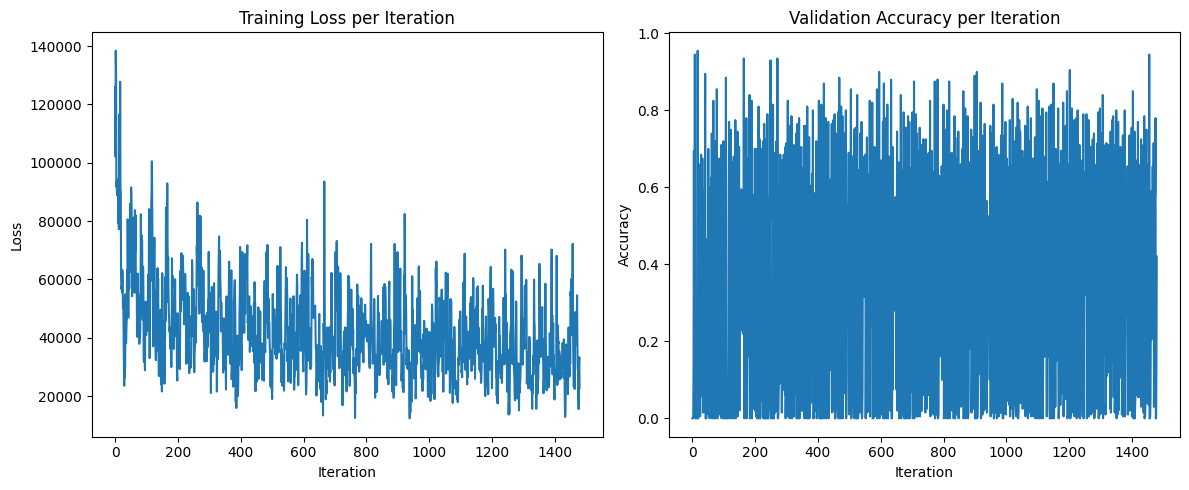

In [16]:
# Create figure with two subplots
plt.figure(figsize=(12,5))

# Plot iteration losses
plt.subplot(1,2,1)
plt.plot(iteration_losses)
plt.title('Training Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Plot iteration accuracies 
plt.subplot(1,2,2)
plt.plot(iteration_accuracies)
plt.title('Validation Accuracy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [21]:
accuracy = get_validation_accuracy(val_tuples)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.4200
